## Import nessacary libraries

In [37]:
import pandas as pd # for data science
import os # operating system
import matplotlib.pyplot as plt # for plotting
from sklearn.model_selection import train_test_split # for splitting the final dataset into train and test

In [38]:
# define some Helper Functions

def count_classes(df: pd.DataFrame, column = 'yield_class'):
    counter = dict(df[column].value_counts())
    print(f'The "{column}" column contains:')
    for k,v in counter.items():
        print(f'\t{v}x {k}')

def count_types(df, column):
    from collections import Counter

    types = Counter([type(i) for i in df[column]])

    print(f'The datatypes in the "{column}" colomn:')
    for k,v in types.items():
        print(f'{v}x {k}')

## Load and inspect data

The data is in a tabular form in a .csv format.

In [39]:
RAW_DATA_FILE = os.path.join('data', 'polymers_rawData.csv')
print(f"Data in '{RAW_DATA_FILE}'")

Data in 'data/polymers_rawData.csv'


With the 'pandas' library, we can read out the data as a dataframe (df).

In [40]:
df = pd.read_csv(RAW_DATA_FILE)

We can print out certain properties of the dataframe, e.g., the total lenght and the columns

In [41]:
print(f"Entries in de dataset: {len(df)}")
print(f"Columns in the dataset: {len(df.columns)} ({df.columns.tolist()})")

Entries in de dataset: 16000
Columns in the dataset: 2 (['sequence', 'E_adh'])


Let's view 5 random entries of the dataframe

In [42]:
df.sample(5)

,sequence,E_adh
7963,B B A A B A A B A A A B A B A A A A A A,8.214659
5745,B A B A B B A B B B B B B B B B A B B B,7.715853
7888,A A A A B A B B B A A A A A B A B A B B,8.517889
14272,B B A B B B B B B B B A A B B B B A A A,8.327265
14843,A A A A B A B B A B B B A A B B B B A B,8.243839


## Format the target (i.e. E_adh)

The aim of this dataset is to predict the adhesive Free Energy from the polymer sequence. Let's inspect only the 'adhesive Free Energy' column

In [43]:
TARGET_COL = 'E_adh'

In [44]:
df[TARGET_COL].sample(5)

2114     7.835486
7977     7.849286
14806    8.674737
660      8.343950
9122     8.368444
Name: E_adh, dtype: float64

In [45]:
count_types(df, TARGET_COL)

The datatypes in the "E_adh" colomn:
16000x <class 'float'>


The median of the "E_adh" column is 8.203660316666666


Text(0, 0.5, 'count')

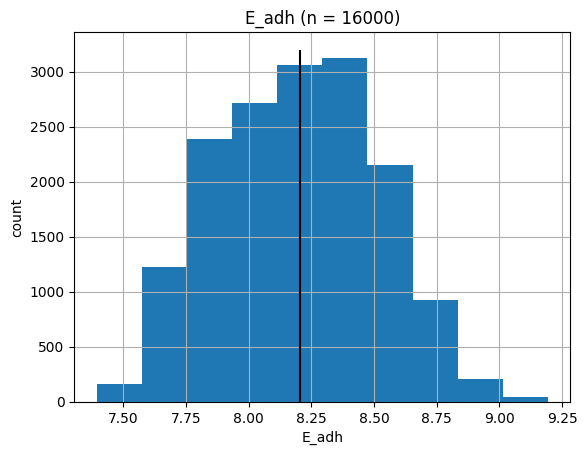

In [46]:
fig, ax = plt.subplots(1,1) #initate plot

# plot target
df[TARGET_COL].hist(ax = ax)

#get median yield
median = df[TARGET_COL].median()
print(f'The median of the "{TARGET_COL}" column is {median}')


#add a vertical line of the median
ax.vlines(median, 0, 3200,
          colors='black')

ax.set_title(f'{TARGET_COL} (n = {len(df)})')
ax.set_xlabel(TARGET_COL)
ax.set_ylabel('count')

The first goal is to create two classes; protocols that lead to a low target property (< median) and protocols that lead to a high target property (> median)

We can do this in a few ways, all leading the same split.

In [47]:

#with pandas qcut () (see https://pandas.pydata.org/docs/reference/api/pandas.qcut.html)

N_CLASSES = 2
CLASS_COL = f'{TARGET_COL}_{N_CLASSES}classes' # name of new column

df[CLASS_COL] = pd.qcut(df[TARGET_COL], #column of interest
                            q = N_CLASSES, # number of classes
                            labels= range(N_CLASSES), #the labels of the classes
                            ) 

count_classes(df, column=CLASS_COL)


The "E_adh_2classes" column contains:
	8000x 0
	8000x 1


### Format the prompt (i.e. the polymer sequence)

Let's create a template string. We will later substitues all the properties in the curly brackets with the respective values of each entry. 

In [54]:
TEMPLATE = "a co-polymer with sequence {SEQUENCE}"

def format_row_representation(row, template):
    prompt = template.format(
        **{
            "SEQUENCE": row["sequence"], # we use the template the format the row. Here the CANMOL in the curly brackets in the previous row is converted into the value of the row
        }
    )

    return prompt

Let's see the entries are converted

In [55]:
row_number = 0 # change to see the prompt for row X
format_row_representation(df.iloc[row_number], TEMPLATE)

'a co-polymer with sequence B B B B A A B B B A B A B B B A B B B B'

loop over the all the rows in the dataframe and create a new 'prompt' column with all the prompts. 

In [58]:
REPRESENTATION_COL = 'sequence'
NEW_REPR_COL = f'{REPRESENTATION_COL}_prompt'

df[NEW_REPR_COL] = [format_row_representation(row, TEMPLATE) for _, row in df.iterrows()]

We can look at the final results, i.e. display only the prompt and the respective 'yield_class' (higher or lower than median)

In [59]:
df[[NEW_REPR_COL, CLASS_COL]].sample(5)

,sequence_prompt,E_adh_2classes
3460,a co-polymer with sequence B B B B B B A A B B...,0
6641,a co-polymer with sequence B A A B B B B A A B...,1
11471,a co-polymer with sequence B A B A B B B B B A...,0
14851,a co-polymer with sequence A A A A A B A A B A...,1
3048,a co-polymer with sequence B A A B B A B A A B...,0


At any point, we can save the dataframe as a csv file

In [61]:
FORMATTED_DATA_FILE = os.path.join('experiment', 'polymers_formattedData.csv')

df.to_csv(FORMATTED_DATA_FILE)

df.to_csv(FORMATTED_DATA_FILE)